# FPH annual report probability visualisation
This notebook loads Fisher & Paykel Healthcare (FPH) annual report BERT outputs (finance, social, env, maori probabilities), combines them with a year column, and plots trends of how often each label is predicted strongly at three thresholds: >0.5, >0.75, >0.95.


In [ ]:
# One-time install of plotting libraries (uncomment if needed)
# %pip install -q matplotlib seaborn


In [27]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

data_dir = Path("data")
csv_paths = sorted(data_dir.glob("preds-FPH*.csv"))

csv_paths


[PosixPath('data/preds-FPH2010.csv'),
 PosixPath('data/preds-FPH2011.csv'),
 PosixPath('data/preds-FPH2012.csv'),
 PosixPath('data/preds-FPH2013.csv'),
 PosixPath('data/preds-FPH2014.csv'),
 PosixPath('data/preds-FPH2015.csv'),
 PosixPath('data/preds-FPH2016.csv'),
 PosixPath('data/preds-FPH2017.csv'),
 PosixPath('data/preds-FPH2018.csv'),
 PosixPath('data/preds-FPH2019.csv'),
 PosixPath('data/preds-FPH2020.csv'),
 PosixPath('data/preds-FPH2021.csv'),
 PosixPath('data/preds-FPH2022.csv'),
 PosixPath('data/preds-FPH2023.csv'),
 PosixPath('data/preds-FPH2024.csv'),
 PosixPath('data/preds-FPH2025.csv')]

In [28]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    frames = []
    for path in paths:
        year = int(path.stem.replace("preds-FPH", ""))
        df = pd.read_csv(path)
        df["year"] = year
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

df = load_yearly(csv_paths)
df.head()


,sentence,source_page,source_pdf,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label,year
0,Annual Report 2010 Generating value through innovation,1,FPH2010,0.004119,0.009551,0.998241,0.000480,2010
1,Our Vision and Values 2 Results in Brief 4 2010 Highlights 5 Chairman’s Report 6 Chief Executive Officer’s Review 10...,2,FPH2010,0.001439,0.998405,0.004545,0.015494,2010
2,Our consistent growth strategy is to provide an expanding range of innovative medical devices which can help to impr...,3,FPH2010,0.013928,0.998605,0.001011,0.001452,2010
3,fisher & paykel healthcare corporation limited – annual report 2010 2 | Vision Our purpose is to increase shareholde...,4,FPH2010,0.114140,0.995225,0.000616,0.000931,2010
4,| 3 fisher & paykel healthcare corporation limited – annual report 2010 Values Patients We will employ our research ...,5,FPH2010,0.008990,0.998562,0.001107,0.002115,2010


In [29]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


,year,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label
count,20546.000000,20546.000000,20546.000000,20546.000000,20546.000000
mean,2018.711720,0.315171,0.491057,0.227464,0.012709
std,4.615925,0.426652,0.474956,0.380834,0.095724
min,2010.000000,0.000124,0.000113,0.000123,0.000037
25%,2015.000000,0.004372,0.002929,0.001903,0.000801
50%,2019.000000,0.012969,0.383949,0.005581,0.001469
75%,2023.000000,0.894316,0.997901,0.271038,0.002617
max,2025.000000,0.999626,0.999440,0.999516,0.999526


In [30]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(id_vars=["year"], value_vars=prob_cols, var_name="label", value_name="probability")
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


,year,label,probability
0,2010,FIN,0.004119
1,2010,FIN,0.001439
2,2010,FIN,0.013928
3,2010,FIN,0.114140
4,2010,FIN,0.008990


In [43]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
def summarize_over_threshold(df_long, threshold):
    agg = (
        df_long.assign(over=df_long["probability"] > threshold)
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total
            mean_prob_over=("probability", lambda s: s[s > threshold].mean()),
        )
        .reset_index()
    )
    # agg["mean_prob_over"] = agg["mean_prob_over"].fillna(0)
    agg["threshold"] = threshold
    return agg


thresholds = [0.5, 0.75, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the 0.5 summary
summaries[0.5].head()


,year,label,total_sentences,over_count,over_share,mean_prob_over,threshold
0,2010,ENV,851,169,0.198590,0.887858,0.5
1,2010,FIN,851,360,0.423032,0.914941,0.5
2,2010,MAORI,851,0,0.000000,NaN,0.5
3,2010,SOC,851,311,0.365452,0.963634,0.5
4,2011,ENV,906,155,0.171082,0.888615,0.5


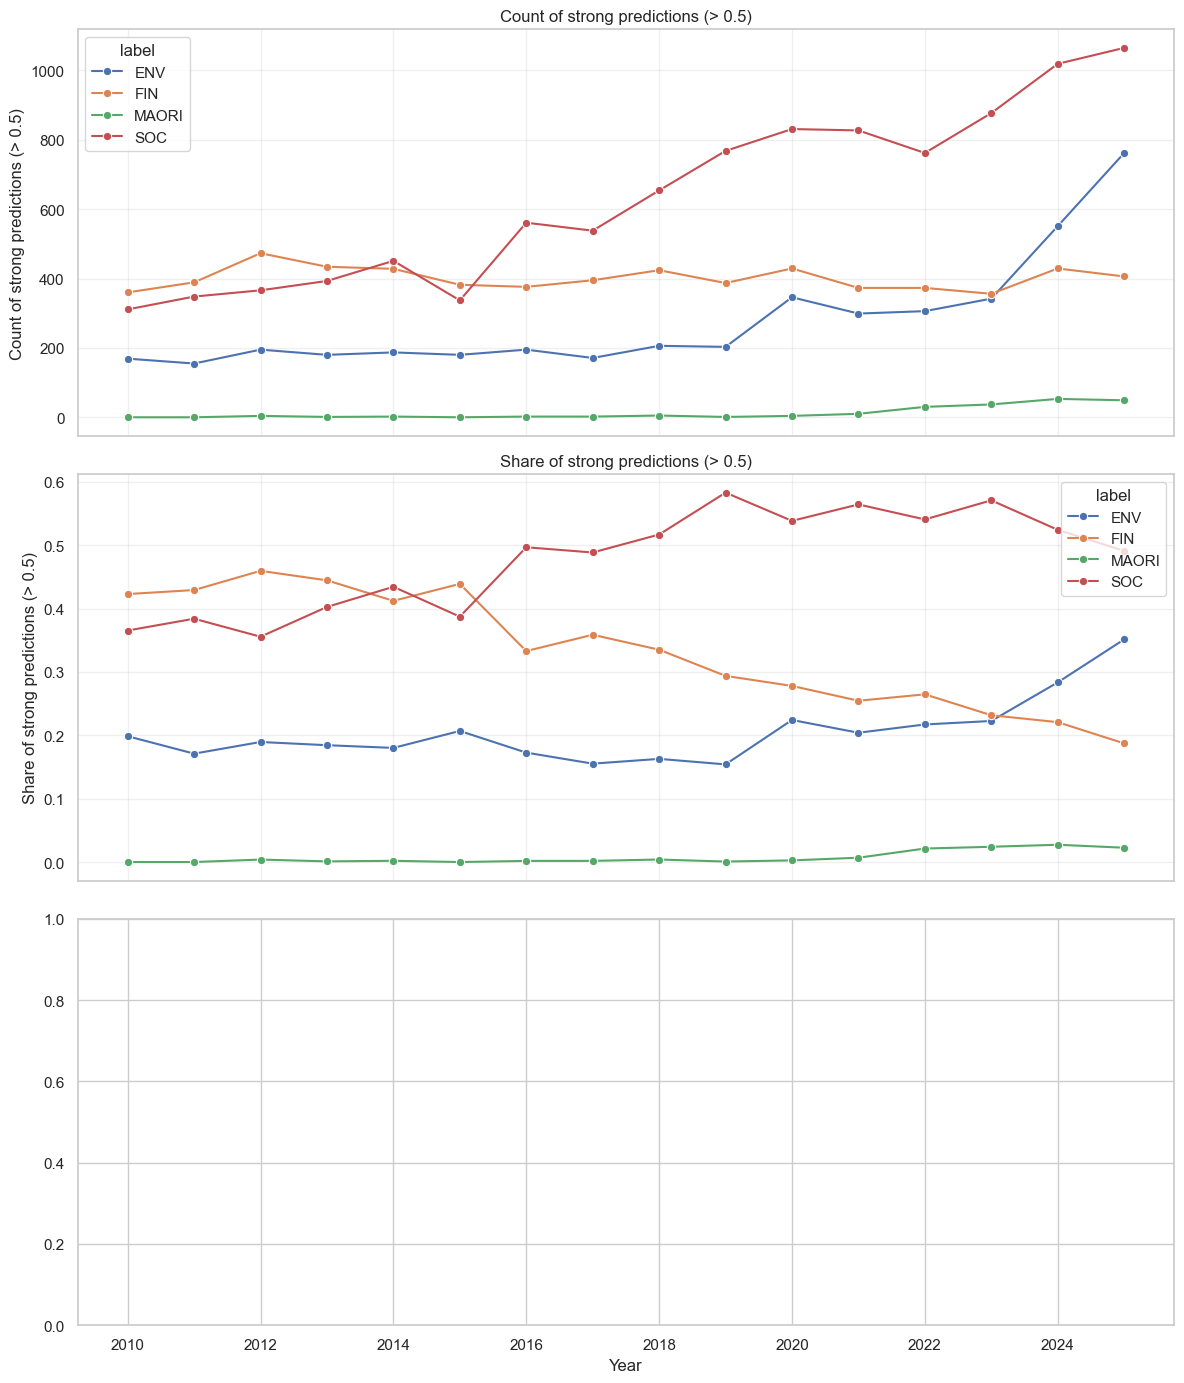

In [47]:
# Combined view for threshold > 0.5 (counts, shares)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.5)"),
    ("over_share", "Share of strong predictions (> 0.5)")
]
summary = summaries[0.5]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


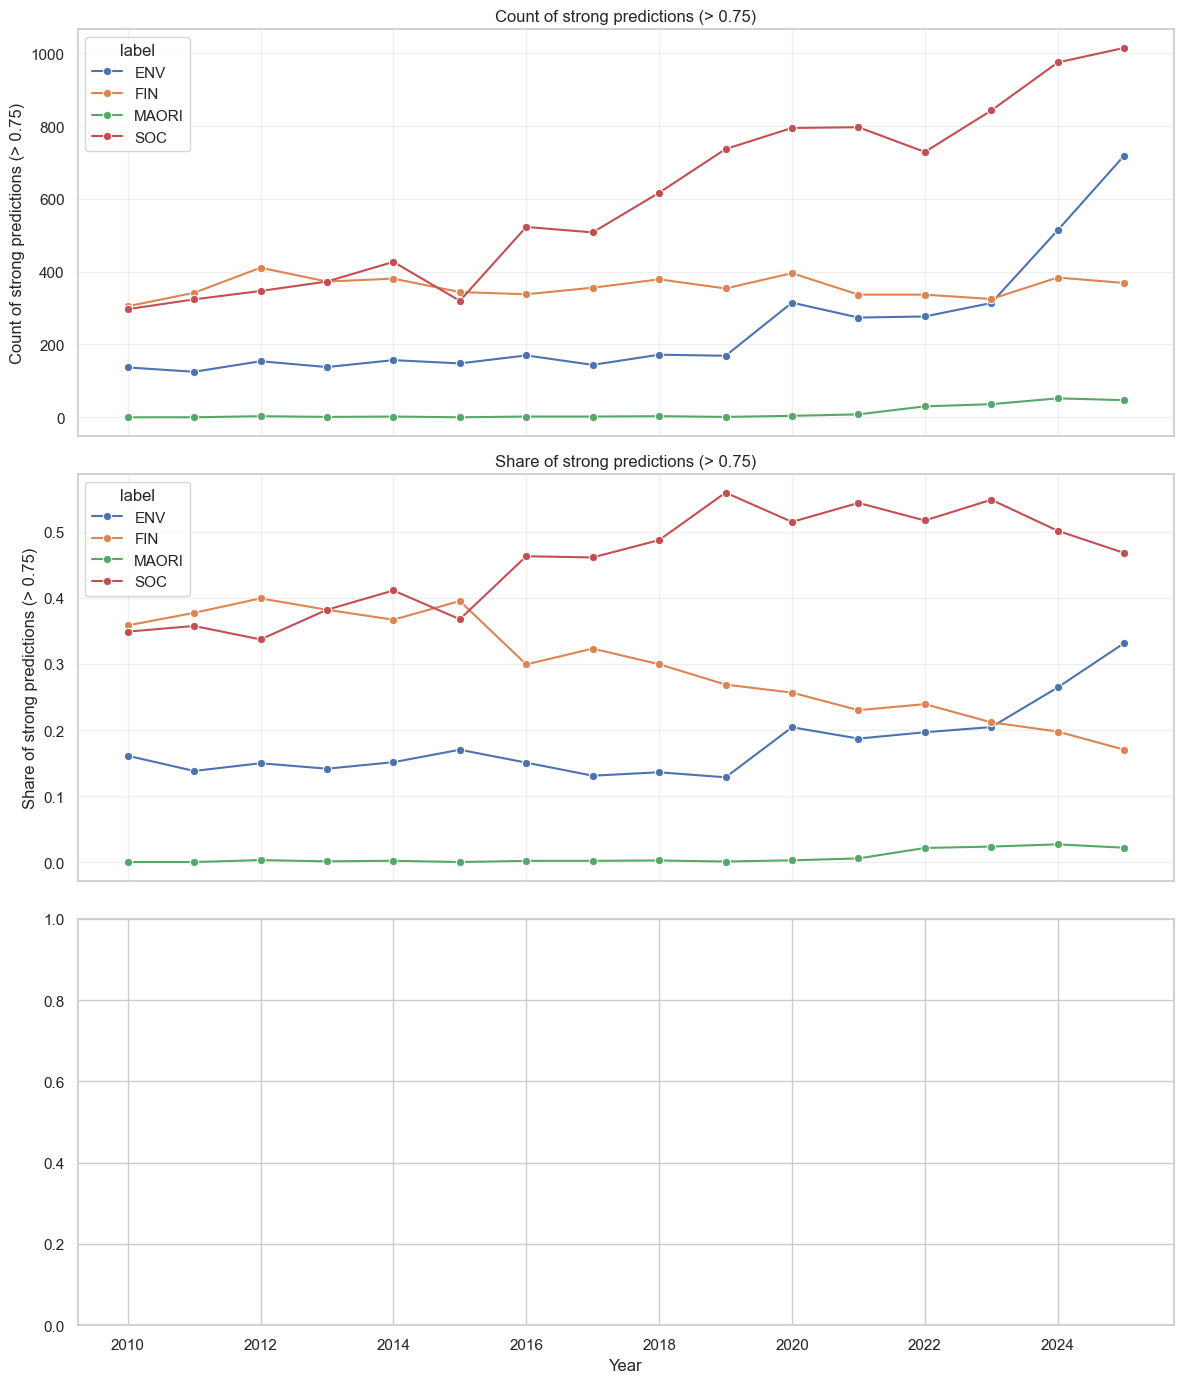

In [48]:
# Combined view for threshold > 0.75 
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.75)"),
    ("over_share", "Share of strong predictions (> 0.75)")
]
summary = summaries[0.75]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


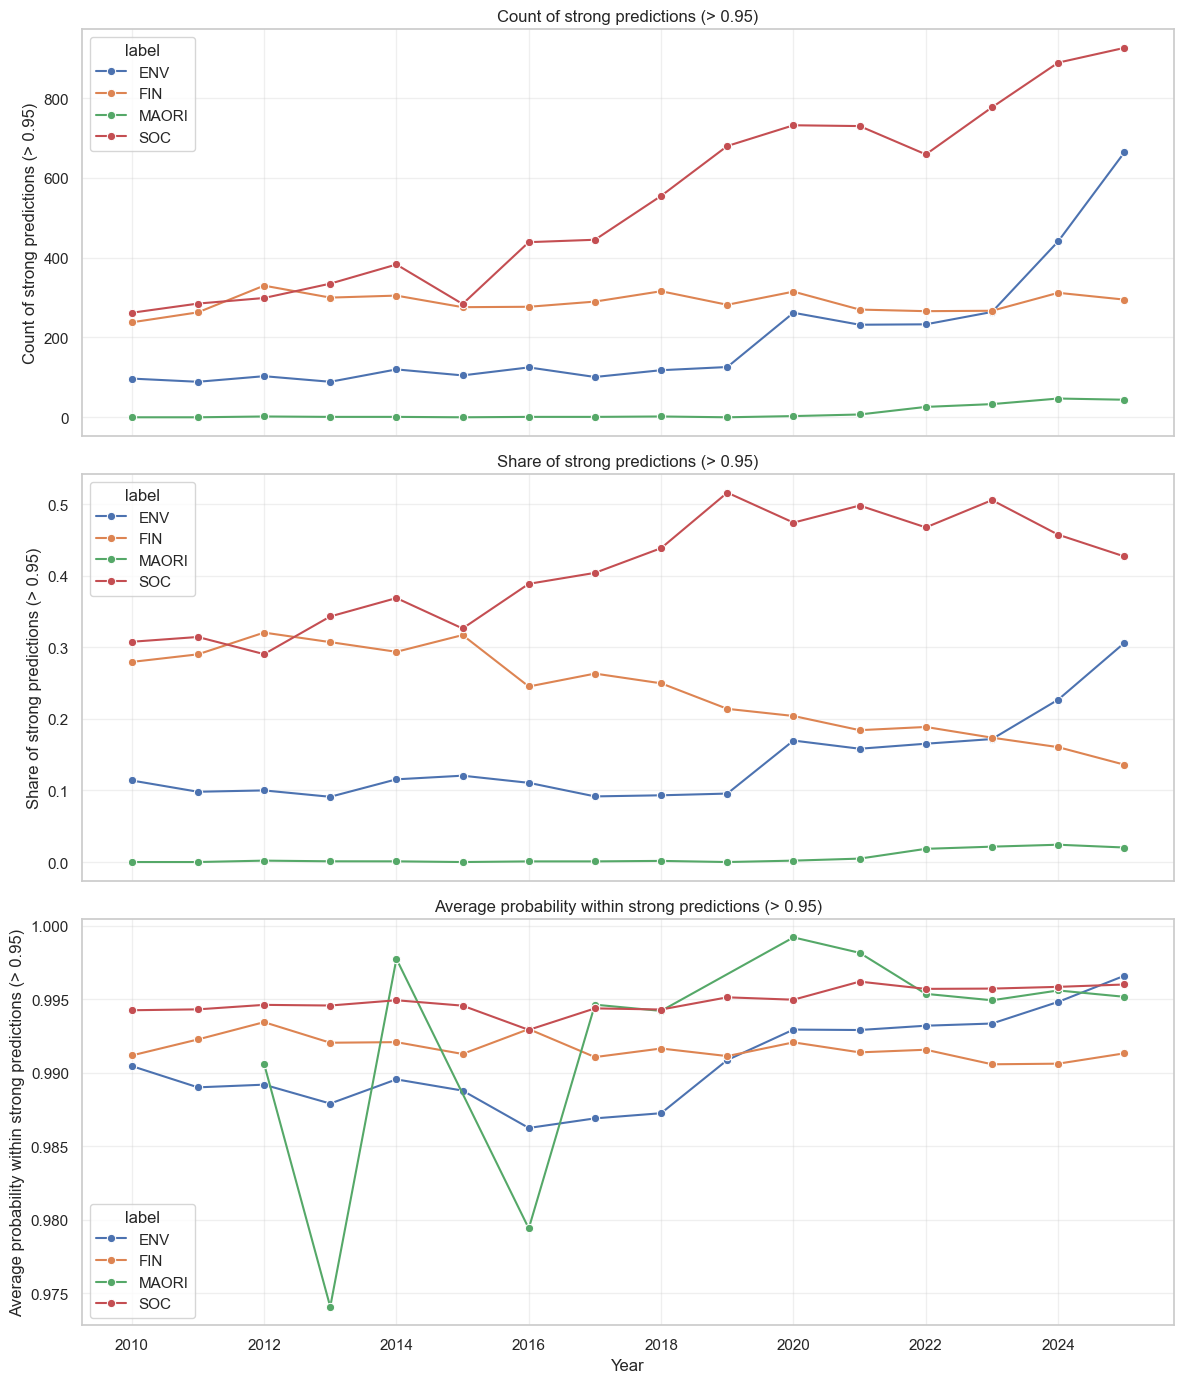

In [46]:
# Combined view for threshold > 0.95 
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.95)"),
    ("over_share", "Share of strong predictions (> 0.95)")
]
summary = summaries[0.95]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- mean_prob_over: average probability for those sentences above the threshold (0 if none above threshold).
